In [1]:
from DataPreparation import *
import math

datasets = ['CheXpert', 'ChestX-ray8', 'Padchest', 'VinDr-CXR', 'MIMIC-CXR-JPG']
img_dir = 'Datasets/Chestxray'
output_dir = 'Datasets/Chestxray'

In [11]:
def read_latents(file_path):
    all_sigmas = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            sigmas = np.sqrt(np.array(parts[1:], dtype=np.float32)) # Variance is stored, take sqrt to get std
            all_sigmas.append(sigmas)
            
    return np.array(all_sigmas)

def find_uncertainty(input_dir, output_dir, reduce=False):
    img_files = list(pathlib.Path(input_dir).rglob("*")) 
    img_files = [f.relative_to(input_dir) for f in img_files if f.is_file()]
    sigma_avg = []

    for file in img_files:
        df, _ = load_image_and_samples(input_dir, output_dir, file)
        node_groups = df.groupby('Node')
        stds = node_groups[['X', 'Y']].std()
        sigma = (stds['X'] + stds['Y']) / 2
        
        if reduce:
            sigma_avg.append(sigma.values.mean())
        else:
            sigma_avg.append(sigma.values)

    return np.array(sigma_avg).flatten()

## Skip-connections

### Promedio

In [13]:
sigmas_ood = {}
sigmas_id = {}

latents_ood = {}
latents_id = {}

for dataset in tqdm(datasets):
    input_path = os.path.join(img_dir, dataset, 'images')
    output_path = os.path.join(output_dir, dataset, 'Output_Skip')
    
    sigmas_ood[dataset] = find_uncertainty(input_path + '/ood', output_path + '/ood', reduce=True)
    sigmas_id[dataset] = find_uncertainty(input_path + '/id', output_path + '/id', reduce=True)

    latents_ood[dataset] = read_latents(f'{img_dir}/{dataset}/ood_output_sigma_skip.txt').mean(axis=1)
    latents_id[dataset] = read_latents(f'{img_dir}/{dataset}/id_output_sigma_skip.txt').mean(axis=1)

100%|██████████| 5/5 [00:31<00:00,  6.40s/it]


#### Posterior

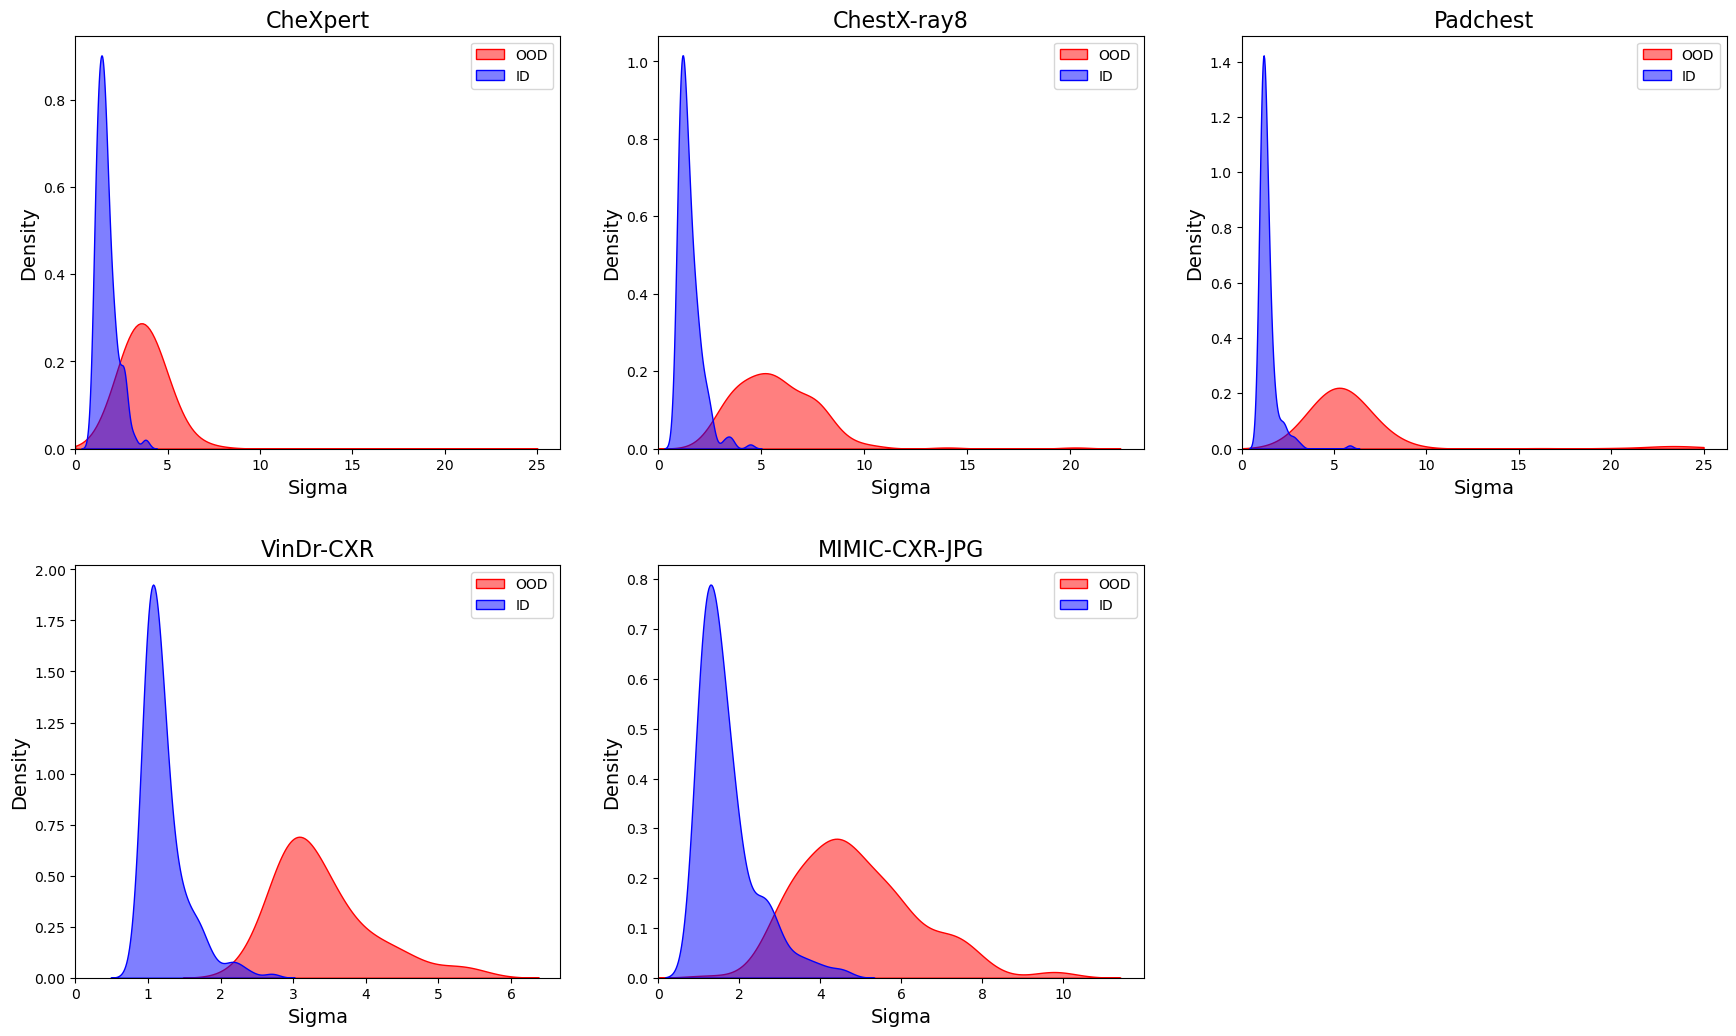

In [4]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]
    sns.kdeplot(sigmas_ood[dataset], fill=True, color="red", label="OOD", ax=ax, alpha=0.5, clip=(0, 25))
    sns.kdeplot(sigmas_id[dataset], fill=True, color="blue", label="ID", ax=ax, alpha=0.5, clip=(0, 25))
    ax.set_xlim(left=0)
    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

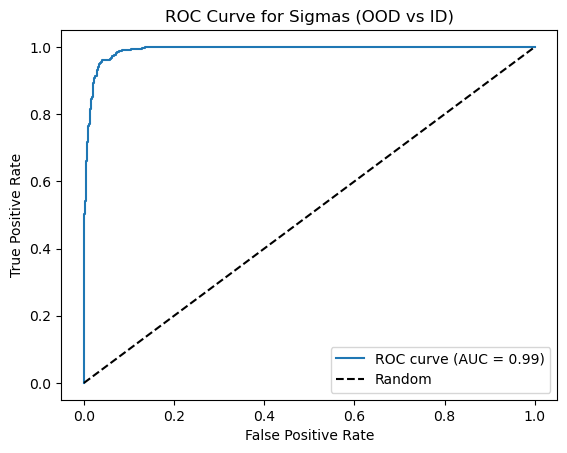

Best threshold: 2.66


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

all_sigmas_ood = np.concatenate([sigmas_ood[ds] for ds in datasets])
all_sigmas_id = np.concatenate([sigmas_id[ds] for ds in datasets])

y_true = np.concatenate([np.zeros(len(all_sigmas_id)), np.ones(len(all_sigmas_ood))])
y_scores = np.concatenate([all_sigmas_id, all_sigmas_ood])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)
best_threshold = thresholds[np.argmax(tpr - fpr)]

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sigmas (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

print(f"Best threshold: {best_threshold:.2f}")

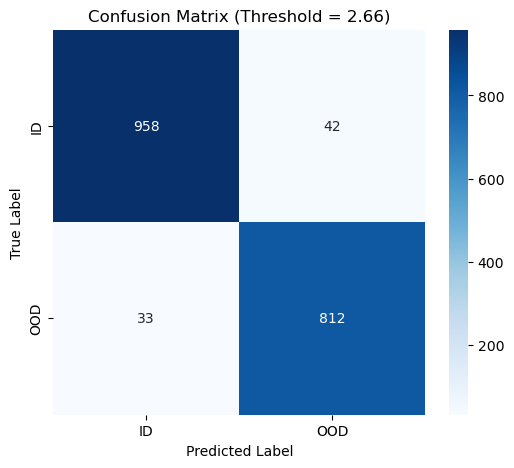

In [29]:
from sklearn.metrics import confusion_matrix

pred = (y_scores >= best_threshold).astype(int)
cm = confusion_matrix(y_true, pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ID','OOD'], yticklabels=['ID','OOD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.show()

#### Espacio latente

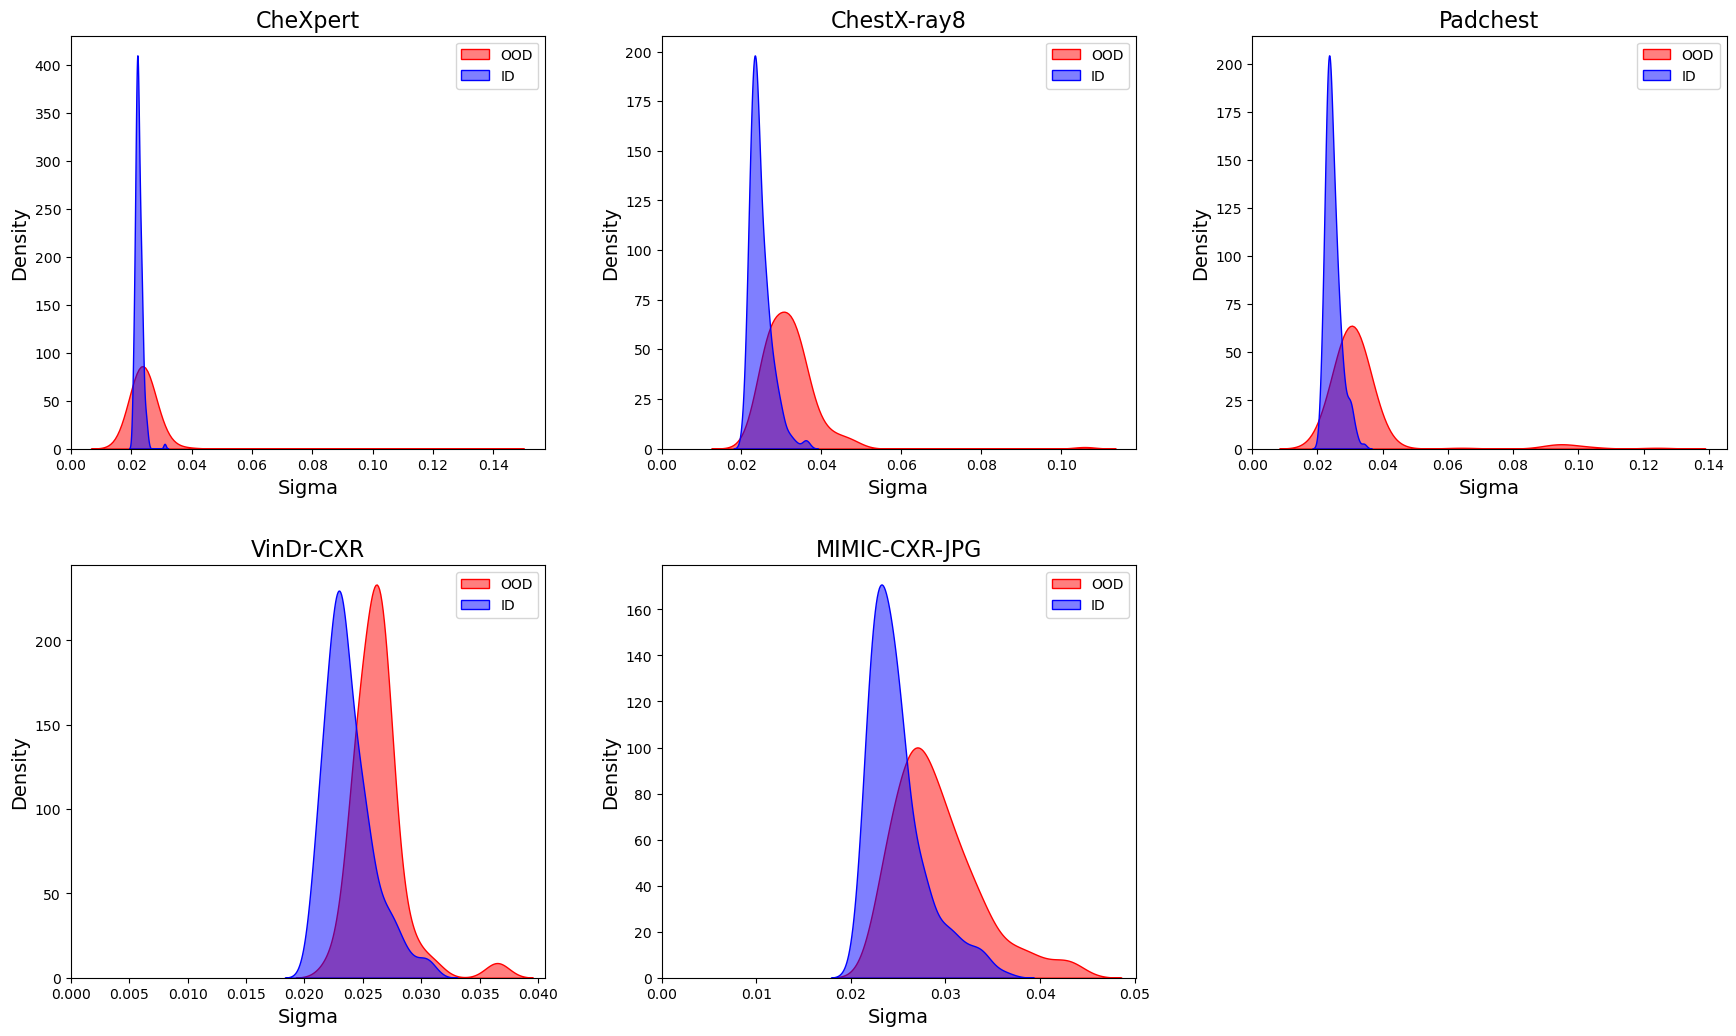

In [ ]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]
    sns.kdeplot(latents_ood[dataset], fill=True, color="red", label="OOD", ax=ax, alpha=0.5, clip=(0, 0.15))
    sns.kdeplot(latents_id[dataset], fill=True, color="blue", label="ID", ax=ax, alpha=0.5, clip=(0, 0.15))
    ax.set_xlim(left=0)
    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

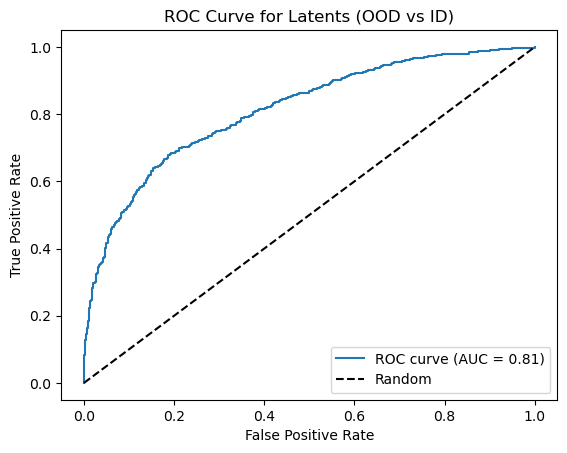

Best threshold: 0.000755


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Concatenate all latent values across datasets
all_latents_ood = np.concatenate([latents_ood[ds] for ds in datasets])
all_latents_id = np.concatenate([latents_id[ds] for ds in datasets])

# Create ground truth labels: 0 = ID, 1 = OOD
y_true = np.concatenate([np.zeros(len(all_latents_id)), np.ones(len(all_latents_ood))])
y_scores = np.concatenate([all_latents_id, all_latents_ood])  # Higher score = more OOD-like

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)

# Find the threshold where TPR - FPR is maximized (Youden’s J statistic)
best_threshold = thresholds[np.argmax(tpr - fpr)]

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Latents (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

# Print optimal threshold
print(f"Best threshold: {best_threshold:.6f}")


### Sin promedio

In [16]:
sigmas_ood = {}
sigmas_id = {}

latents_ood = {}
latents_id = {}

for dataset in tqdm(datasets):
    input_path = os.path.join(img_dir, dataset, 'images')
    output_path = os.path.join(output_dir, dataset, 'Output_Skip')
    
    sigmas_ood[dataset] = find_uncertainty(input_path + '/ood', output_path + '/ood')
    sigmas_id[dataset] = find_uncertainty(input_path + '/id', output_path + '/id')

    latents_ood[dataset] = read_latents(f'{img_dir}/{dataset}/ood_output_sigma_skip.txt').flatten()
    latents_id[dataset] = read_latents(f'{img_dir}/{dataset}/id_output_sigma_skip.txt').flatten()

100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


#### Posterior 

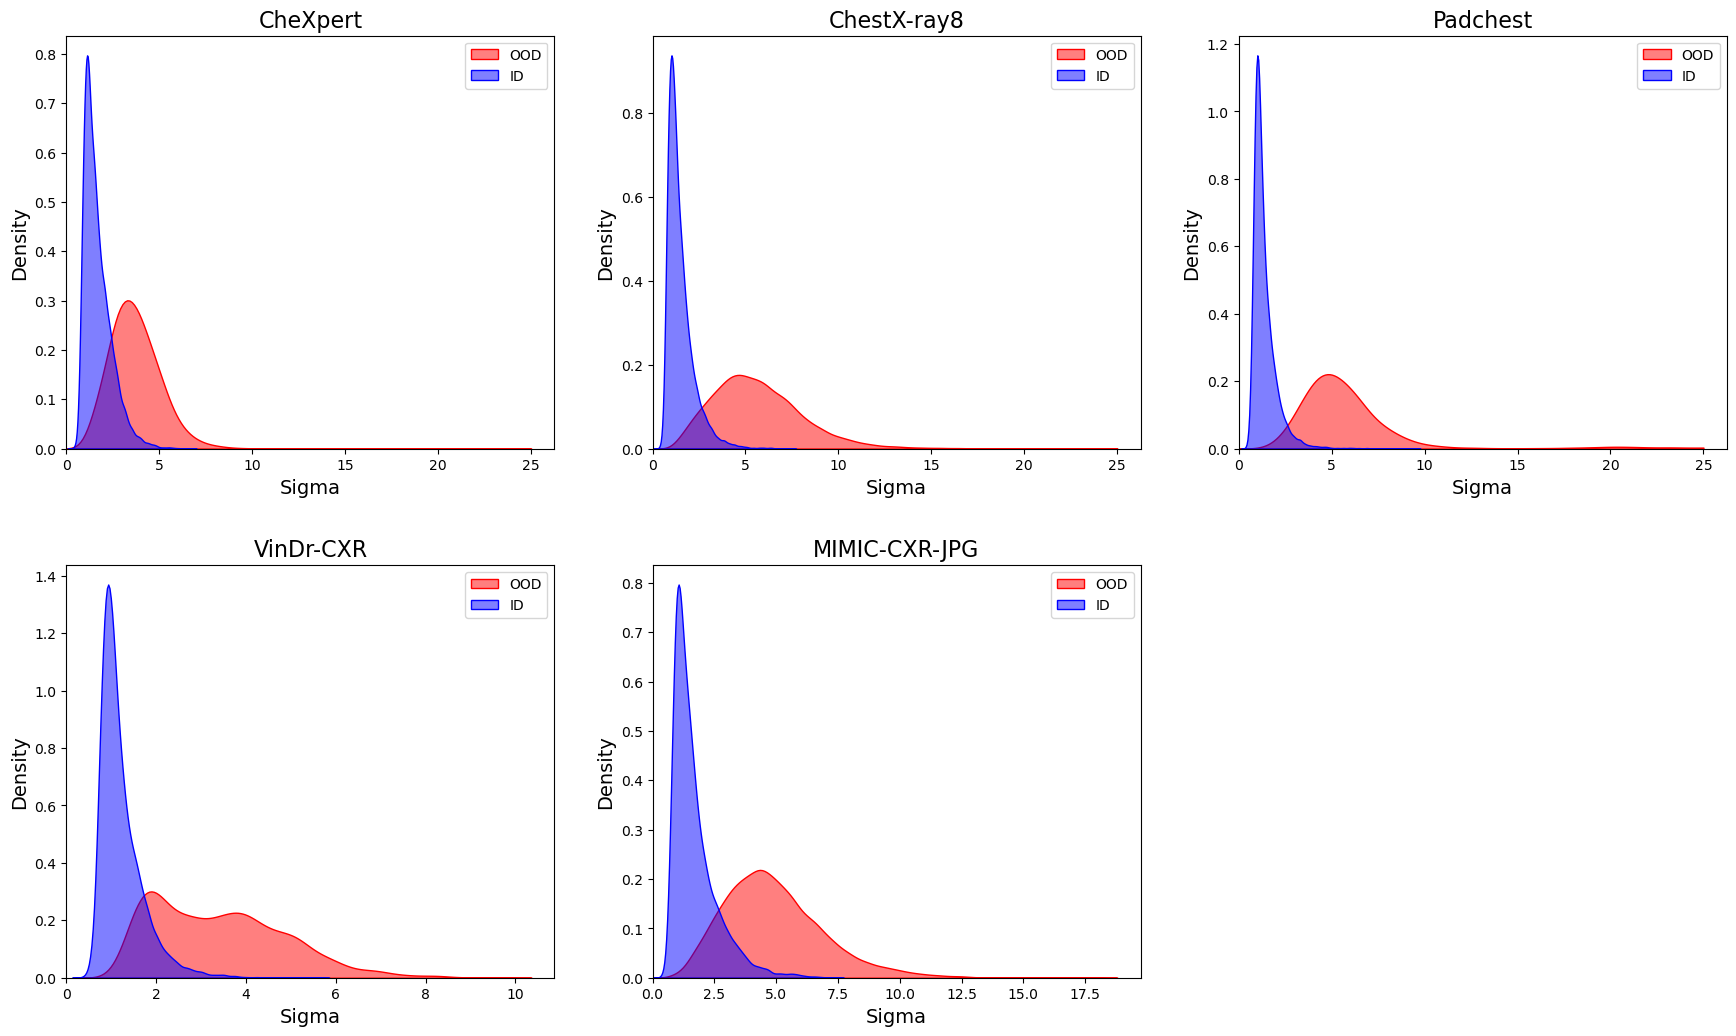

In [23]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]
    sns.kdeplot(sigmas_ood[dataset], fill=True, color="red", label="OOD", ax=ax, alpha=0.5, clip=(0, 25))
    sns.kdeplot(sigmas_id[dataset], fill=True, color="blue", label="ID", ax=ax, alpha=0.5, clip=(0, 25))
    ax.set_xlim(left=0)
    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

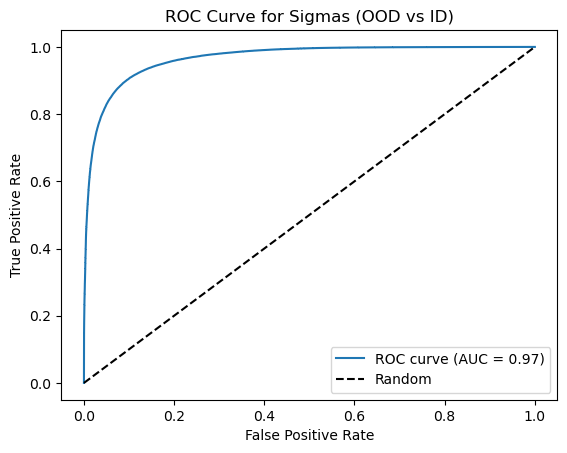

Best threshold: 2.46


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

all_sigmas_ood = np.concatenate([sigmas_ood[ds] for ds in datasets])
all_sigmas_id = np.concatenate([sigmas_id[ds] for ds in datasets])

y_true = np.concatenate([np.zeros(len(all_sigmas_id)), np.ones(len(all_sigmas_ood))])
y_scores = np.concatenate([all_sigmas_id, all_sigmas_ood])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)
best_threshold = thresholds[np.argmax(tpr - fpr)]

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sigmas (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

print(f"Best threshold: {best_threshold:.2f}")


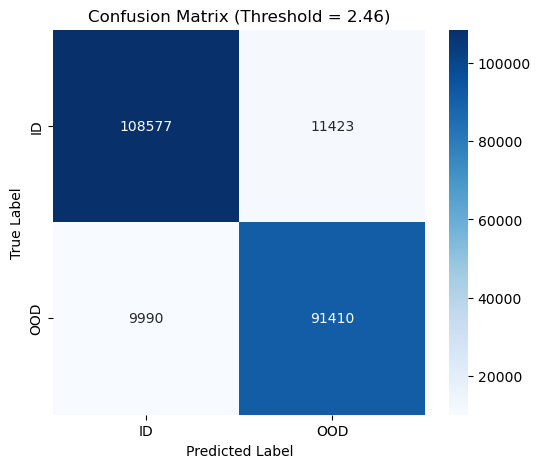

In [25]:
from sklearn.metrics import confusion_matrix

pred = (y_scores >= best_threshold).astype(int)
cm = confusion_matrix(y_true, pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ID','OOD'], yticklabels=['ID','OOD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.show()

#### Espacio latente

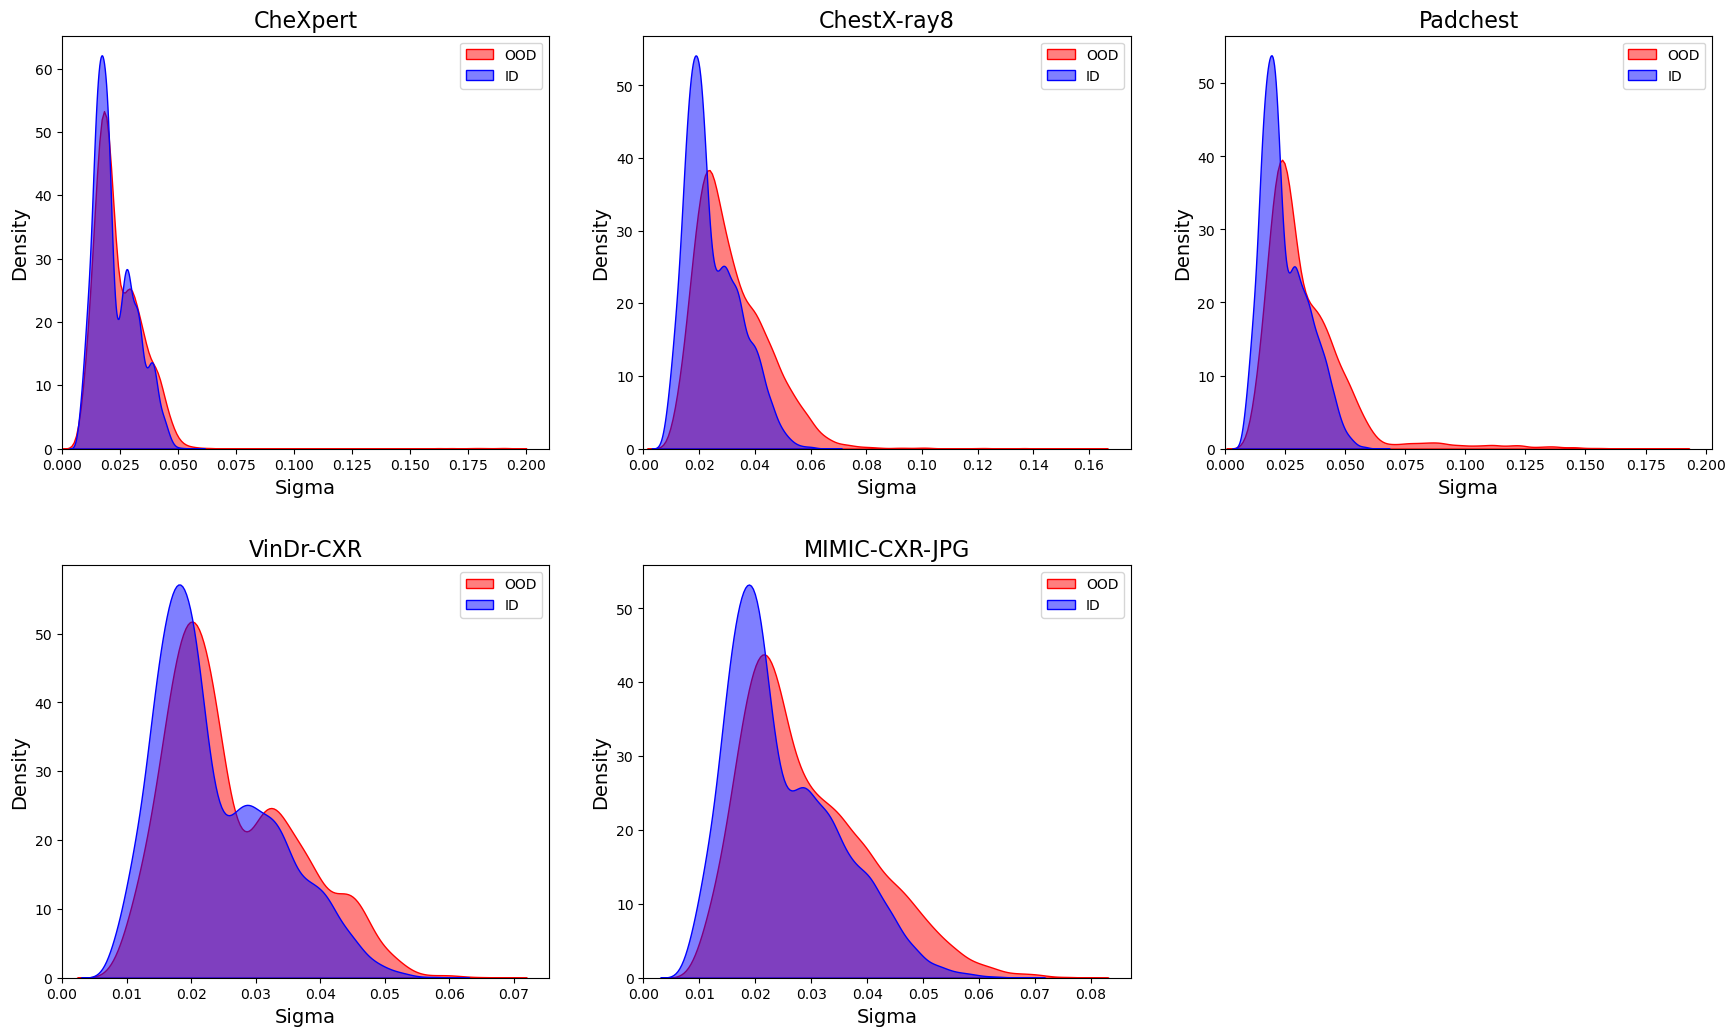

In [ ]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]
    sns.kdeplot(latents_ood[dataset], fill=True, color="red", label="OOD", ax=ax, alpha=0.5, clip=(0, 0.2))
    sns.kdeplot(latents_id[dataset], fill=True, color="blue", label="ID", ax=ax, alpha=0.5, clip=(0,0.2))
    ax.set_xlim(left=0)
    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

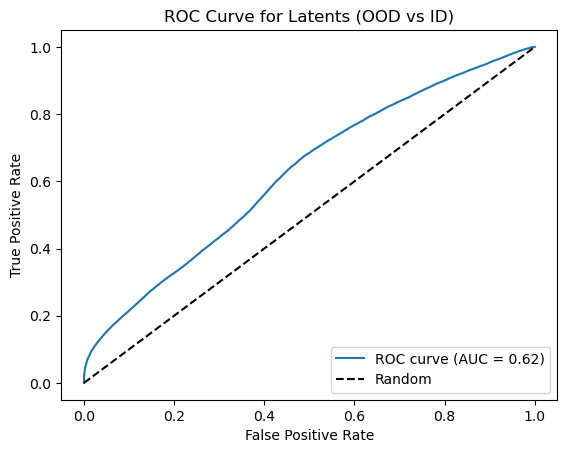

Best threshold: 0.021671


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Concatenate all latent values across datasets
all_latents_ood = np.concatenate([latents_ood[ds] for ds in datasets])
all_latents_id = np.concatenate([latents_id[ds] for ds in datasets])

# Create ground truth labels: 0 = ID, 1 = OOD
y_true = np.concatenate([np.zeros(len(all_latents_id)), np.ones(len(all_latents_ood))])
y_scores = np.concatenate([all_latents_id, all_latents_ood])  # Higher score = more OOD-like

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)

# Find the threshold where TPR - FPR is maximized (Youden’s J statistic)
best_threshold = thresholds[np.argmax(tpr - fpr)]

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Latents (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

# Print optimal threshold
print(f"Best threshold: {best_threshold:.6f}")


## No Skip-Connections


### Promedio

In [21]:
sigmas_ood = {}
sigmas_id = {}

latents_ood = {}
latents_id = {}

for dataset in tqdm(datasets):
    input_path = os.path.join(img_dir, dataset, 'images')
    output_path = os.path.join(output_dir, dataset, 'Output_NoSkip')
    
    sigmas_ood[dataset] = find_uncertainty(input_path + '/ood', output_path + '/ood', reduce=True)
    sigmas_id[dataset] = find_uncertainty(input_path + '/id', output_path + '/id', reduce=True)

    latents_ood[dataset] = read_latents(f'{img_dir}/{dataset}/ood_output_sigma_noskip.txt').mean(axis=1)
    latents_id[dataset] = read_latents(f'{img_dir}/{dataset}/id_output_sigma_noskip.txt').mean(axis=1)

100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


#### Posterior

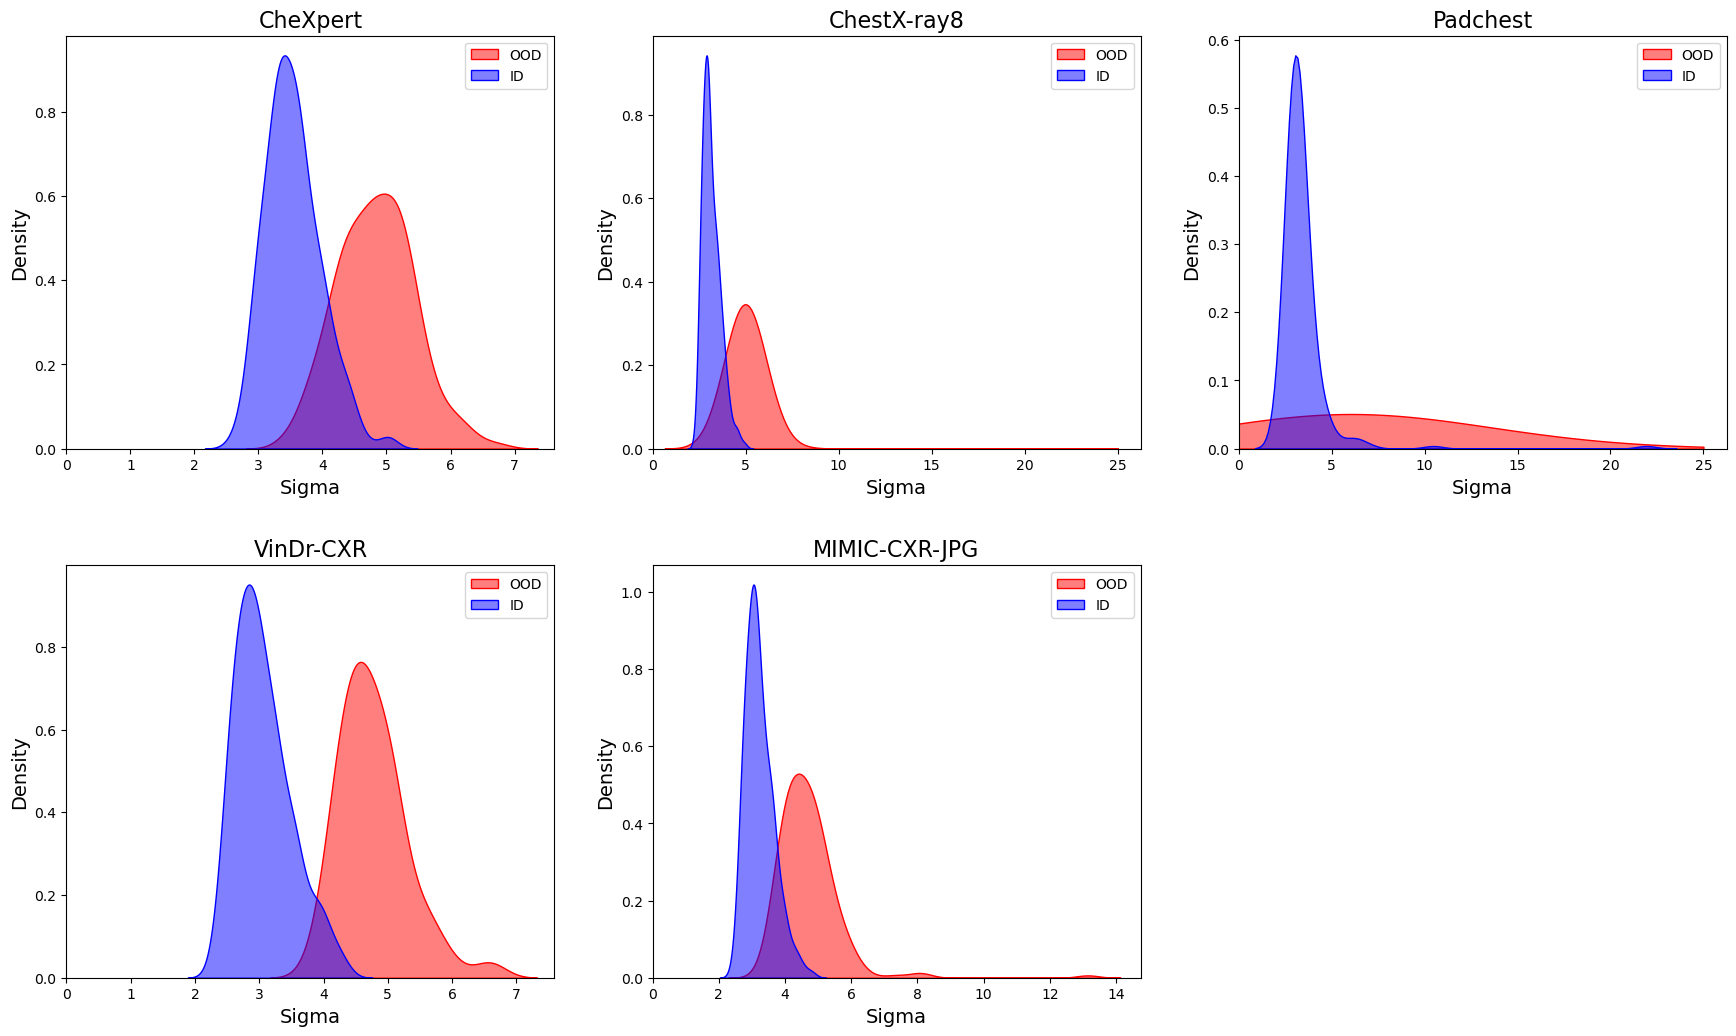

In [23]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]

    sns.kdeplot(sigmas_ood[dataset], fill=True, color="red", label="OOD", ax=ax, alpha=0.5, clip=(0, 25))
    sns.kdeplot(sigmas_id[dataset], fill=True, color="blue", label="ID", ax=ax, alpha=0.5, clip=(0, 25))
    ax.set_xlim(left=0)
    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_xlim(left=0)

    ax.legend()


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

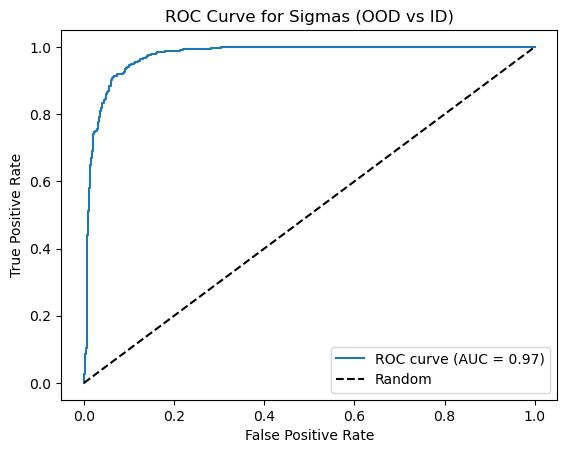

Best threshold: 4.06


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

all_sigmas_ood = np.concatenate([np.array(sigmas_ood[ds]) for ds in datasets])
all_sigmas_id = np.concatenate([np.array(sigmas_id[ds]) for ds in datasets])

y_true = np.concatenate([np.zeros(len(all_sigmas_id)), np.ones(len(all_sigmas_ood))])
y_scores = np.concatenate([all_sigmas_id, all_sigmas_ood])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)
best_threshold = thresholds[np.argmax(tpr - fpr)]

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sigmas (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

print(f"Best threshold: {best_threshold:.2f}")


#### Espacio latente

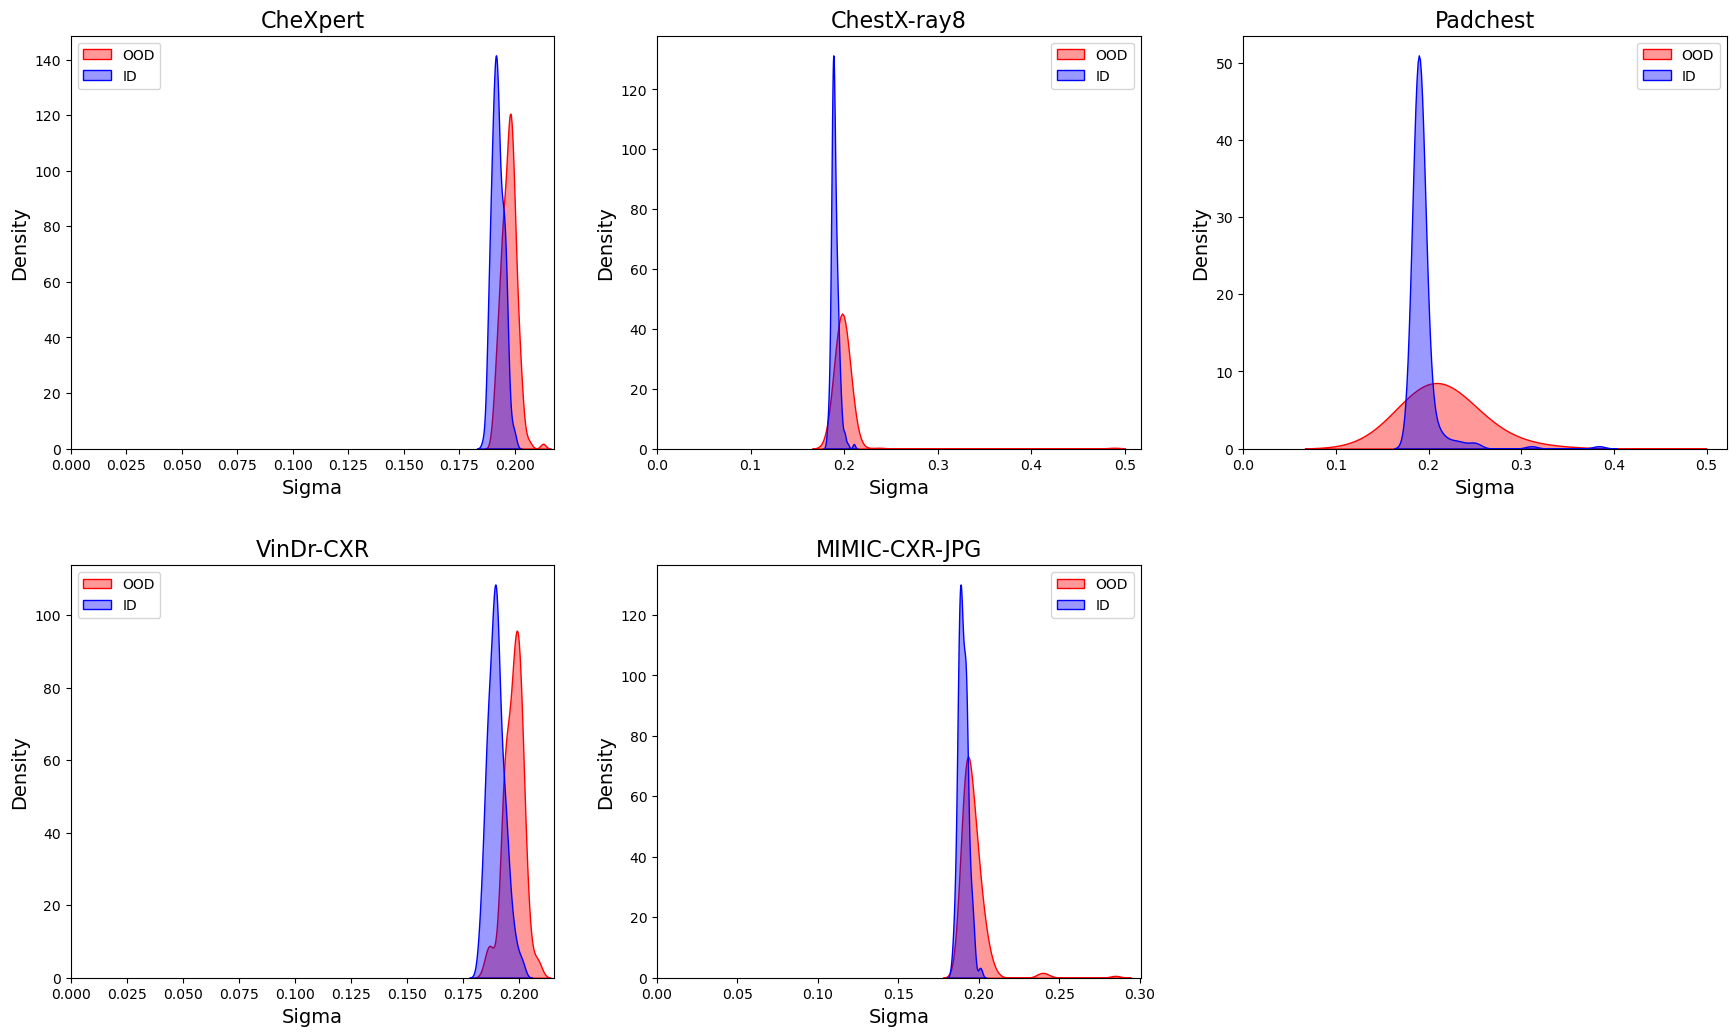

In [24]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]
    sns.kdeplot(np.sqrt(latents_ood[dataset]), fill=True, color="red", label="OOD", ax=ax, alpha=0.4, clip=(0, 0.5))
    sns.kdeplot(np.sqrt(latents_id[dataset]), fill=True, color="blue", label="ID", ax=ax, alpha=0.4, clip=(0, 0.5))
    ax.set_xlim(left=0)
    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

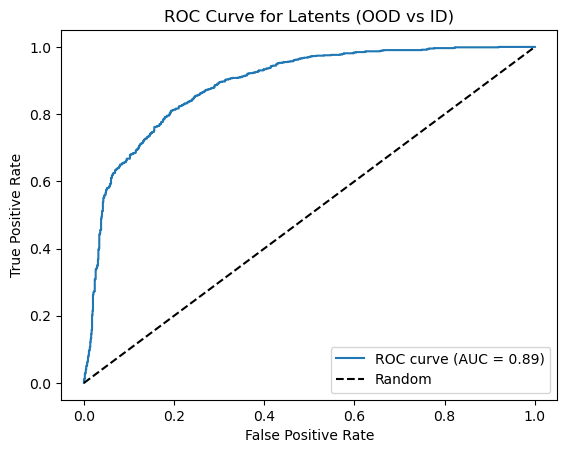

Best threshold: 0.037356


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Concatenate all latent values across datasets
all_latents_ood = np.concatenate([np.array(latents_ood[ds]) for ds in datasets])
all_latents_id = np.concatenate([np.array(latents_id[ds]) for ds in datasets])

# Create ground truth labels: 0 = ID, 1 = OOD
y_true = np.concatenate([np.zeros(len(all_latents_id)), np.ones(len(all_latents_ood))])
y_scores = np.concatenate([all_latents_id, all_latents_ood])  # Higher score = more OOD-like

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)

# Find the threshold where TPR - FPR is maximized (Youden’s J statistic)
best_threshold = thresholds[np.argmax(tpr - fpr)]

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Latents (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

# Print optimal threshold
print(f"Best threshold: {best_threshold:.6f}")


### Sin promedio

In [26]:
sigmas_ood = {}
sigmas_id = {}

latents_ood = {}
latents_id = {}

for dataset in tqdm(datasets):
    input_path = os.path.join(img_dir, dataset, 'images')
    output_path = os.path.join(output_dir, dataset, 'Output_NoSkip')
    
    sigmas_ood[dataset] = find_uncertainty(input_path + '/ood', output_path + '/ood', reduce=False)
    sigmas_id[dataset] = find_uncertainty(input_path + '/id', output_path + '/id', reduce=False)

    latents_ood[dataset] = read_latents(f'{img_dir}/{dataset}/ood_output_sigma_noskip.txt').flatten()
    latents_id[dataset] = read_latents(f'{img_dir}/{dataset}/id_output_sigma_noskip.txt').flatten()

100%|██████████| 5/5 [00:33<00:00,  6.65s/it]


#### Posterior

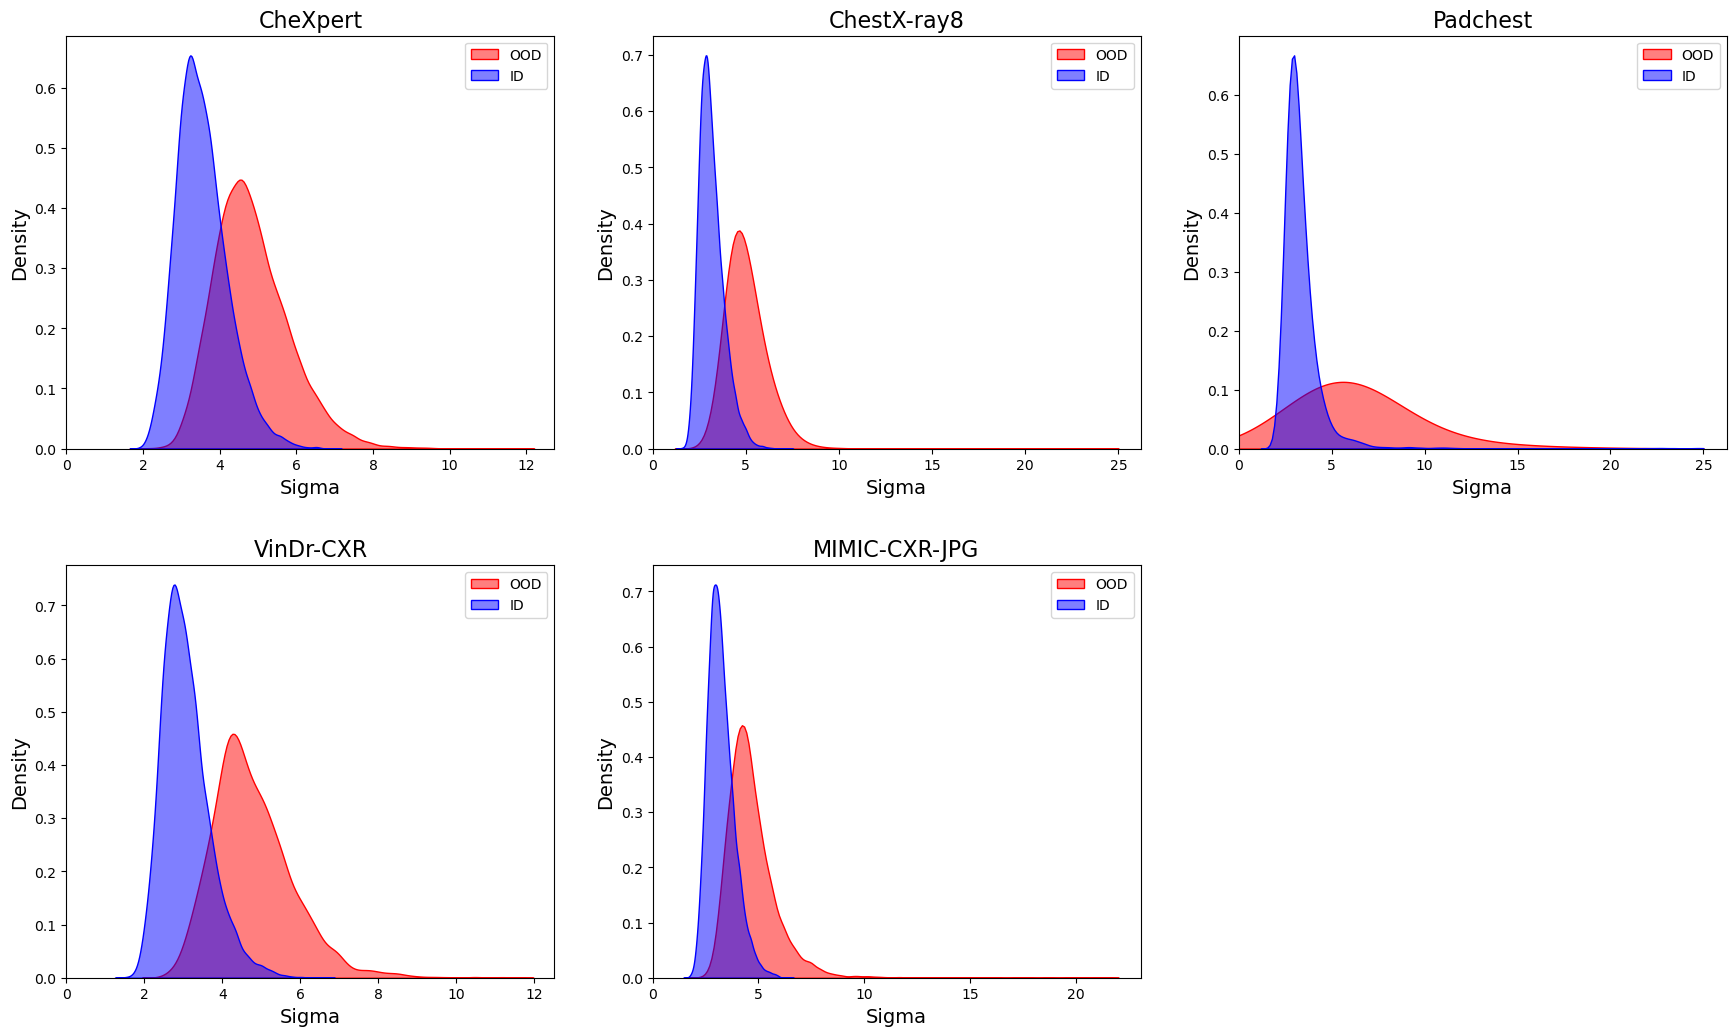

In [27]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]

    sns.kdeplot(sigmas_ood[dataset], fill=True, color="red", label="OOD", ax=ax, alpha=0.5, clip=(0, 25))
    sns.kdeplot(sigmas_id[dataset], fill=True, color="blue", label="ID", ax=ax, alpha=0.5, clip=(0, 25))
    ax.set_xlim(left=0)
    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_xlim(left=0)

    ax.legend()


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

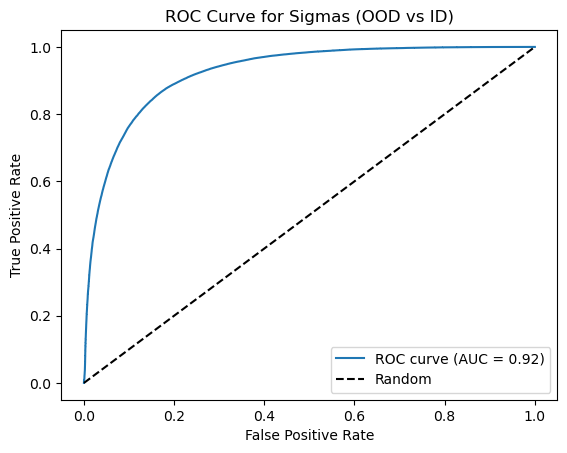

Best threshold: 3.85


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

all_sigmas_ood = np.concatenate([np.array(sigmas_ood[ds]) for ds in datasets])
all_sigmas_id = np.concatenate([np.array(sigmas_id[ds]) for ds in datasets])

y_true = np.concatenate([np.zeros(len(all_sigmas_id)), np.ones(len(all_sigmas_ood))])
y_scores = np.concatenate([all_sigmas_id, all_sigmas_ood])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)
best_threshold = thresholds[np.argmax(tpr - fpr)]

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sigmas (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

print(f"Best threshold: {best_threshold:.2f}")


#### Espacio latente

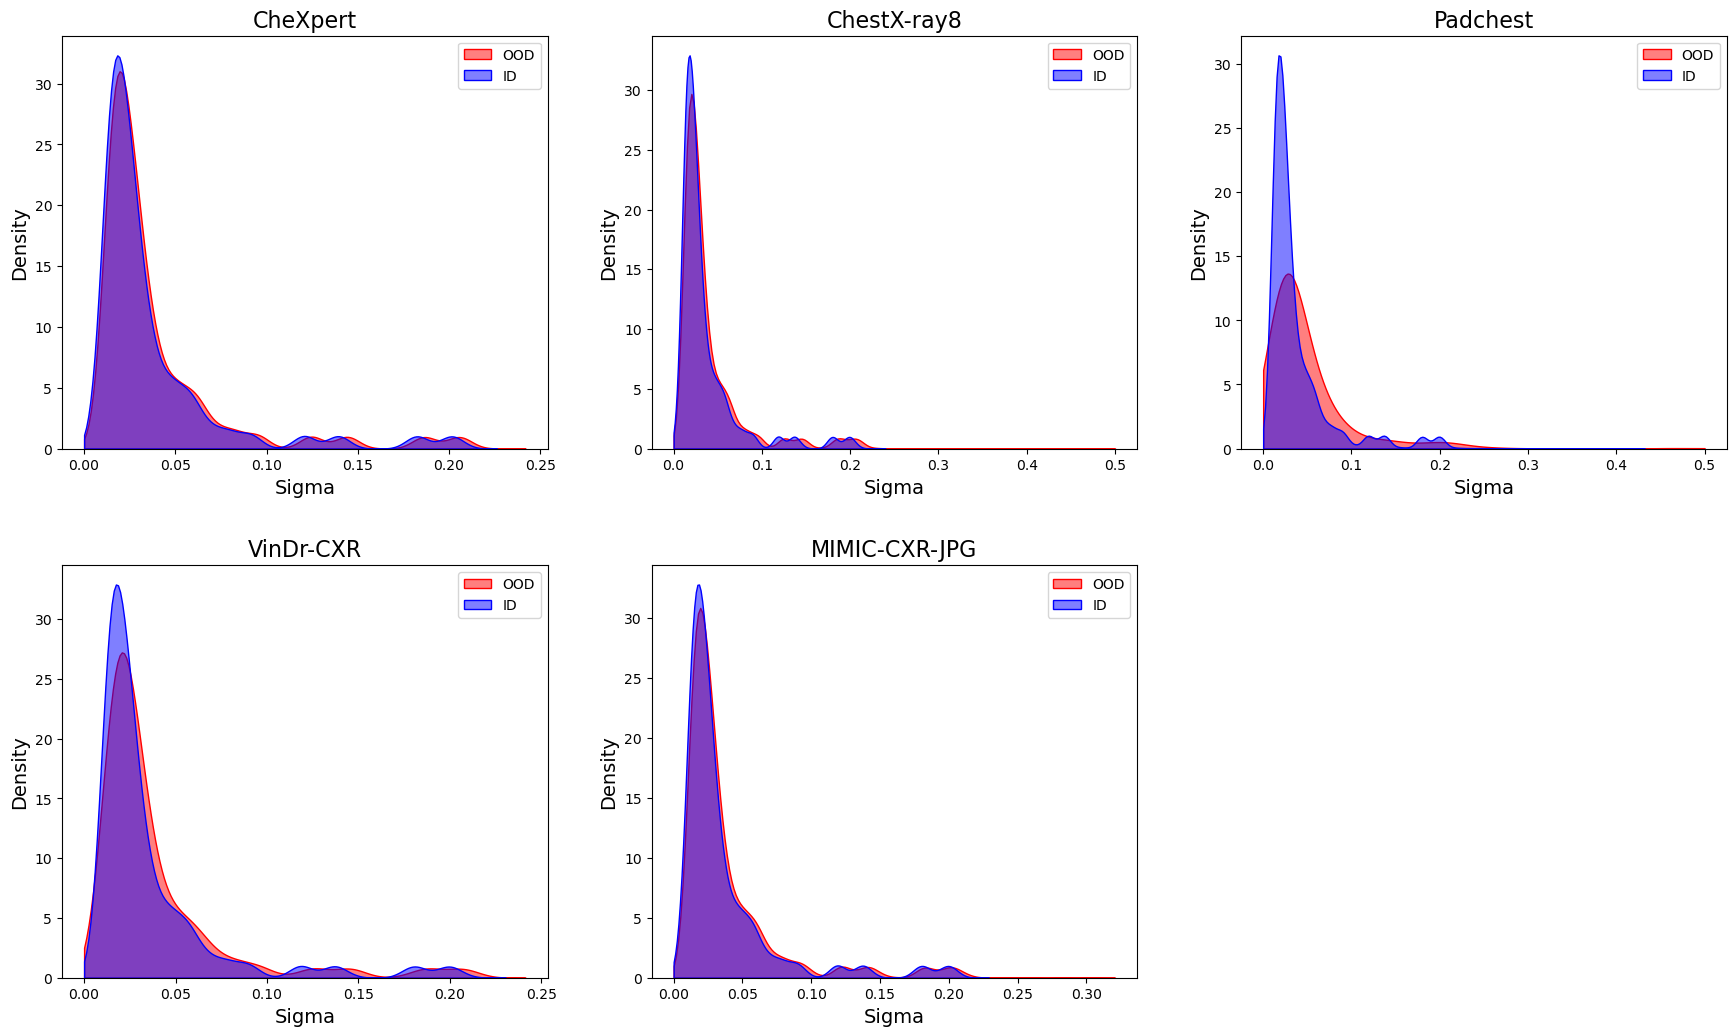

In [29]:
n = len(datasets)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, dataset in enumerate(datasets):
    ax = axes[i]

    sns.kdeplot(latents_ood[dataset], fill=True, color="red", label="OOD", ax=ax, alpha=0.5, clip=(0, 0.5))
    sns.kdeplot(latents_id[dataset], fill=True, color="blue", label="ID", ax=ax, alpha=0.5, clip=(0, 0.5))

    ax.set_title(dataset, fontsize=16)
    ax.set_xlabel("Sigma", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

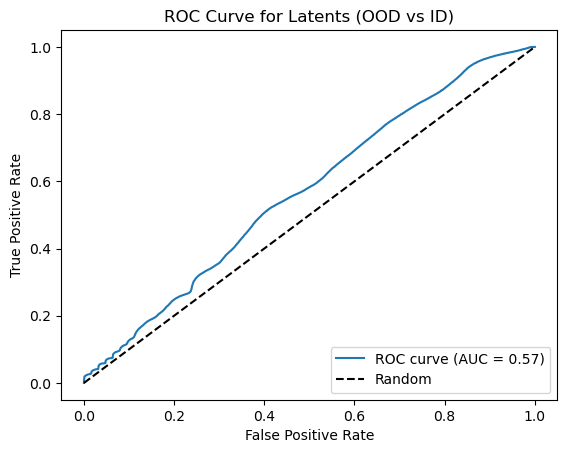

Best threshold: 0.026575


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Concatenate all latent values across datasets
all_latents_ood = np.concatenate([np.array(latents_ood[ds]) for ds in datasets])
all_latents_id = np.concatenate([np.array(latents_id[ds]) for ds in datasets])

# Create ground truth labels: 0 = ID, 1 = OOD
y_true = np.concatenate([np.zeros(len(all_latents_id)), np.ones(len(all_latents_ood))])
y_scores = np.concatenate([all_latents_id, all_latents_ood])  # Higher score = more OOD-like

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)

# Find the threshold where TPR - FPR is maximized (Youden’s J statistic)
best_threshold = thresholds[np.argmax(tpr - fpr)]

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Latents (OOD vs ID)')
plt.legend(loc="lower right")
plt.show()

# Print optimal threshold
print(f"Best threshold: {best_threshold:.6f}")
